##### **Author(s)**:  Zareef Jafar, Anowar J. Shajib

Acknowledgement: S M Rafee Adnan, Fahim Rajit Hossain

In [1]:
import time

import h5py
import joblib
import matplotlib.pyplot as plt

import os
# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import corner
%matplotlib inline

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

For the first example of lensing data, no PSF was used to create the data.
Therefore, `psf_type` is set to `NONE`. For real data, there has to be a PSF
. We will work with PSFs in later examples.

In [2]:
with h5py.File("./DESIJ1554+0443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("./psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

kwargs_data

{'background_rms': 0.0137866616807371,
 'dec_at_xy_0': -4.839999999999995,
 'exposure_time': array([[526.58203, 420.42545, 478.3544 , ..., 533.4616 , 399.34912,
         517.8962 ],
        [424.4987 , 484.88034, 551.4943 , ..., 489.48572, 418.86212,
         522.29926],
        [384.8858 , 505.07867, 419.24973, ..., 487.39197, 435.3952 ,
         508.632  ],
        ...,
        [498.08844, 443.47632, 427.97556, ..., 498.2728 , 343.41418,
         507.6376 ],
        [427.0364 , 436.4274 , 502.66687, ..., 506.71988, 465.6584 ,
         510.76175],
        [410.01215, 504.86472, 437.02142, ..., 376.98816, 511.93005,
         502.43845]], dtype=float32),
 'image_data': array([[ 0.01204894,  0.00179044,  0.0021683 , ..., -0.01431787,
          0.01175164, -0.00076203],
        [ 0.00971342,  0.00726407,  0.00480296, ..., -0.00116851,
         -0.00183223, -0.01219291],
        [-0.00765296, -0.00050401,  0.00288014, ..., -0.02108379,
         -0.02647783, -0.01446793],
        ...,
     

/tmp/ipykernel_16395/3612032868.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


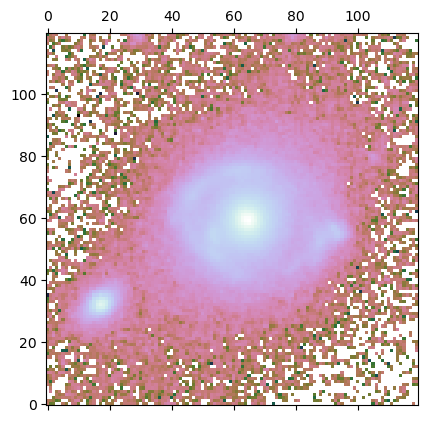

In [3]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")

In [4]:
# To make a mask using lenstronomy functions, here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 5  # arcsecond
r2 = 2.5
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.5,
    lens_center_dec - 2.2,
    1,
    1,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.5,
    lens_center_dec + 1.7,
    0.5,
    0.5,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.7,
    lens_center_dec - 0.4,
    0.3,
    0.3,
    0,
)

mask = (1 - mask_outer_1) * (1 - mask_ext_1) * (1 - mask_ext_2)
mask[mask >= 1] = 1
mask[mask < 0] = 0


mask_img = mask.reshape(num_pix, num_pix)

## Applying mask

/tmp/ipykernel_16395/4187877492.py:3: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
/tmp/ipykernel_16395/4187877492.py:5: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_16395/4187877492.py:5: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_16395/4187877492.py:8: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


Text(0.5, 1.0, 'Masked image')

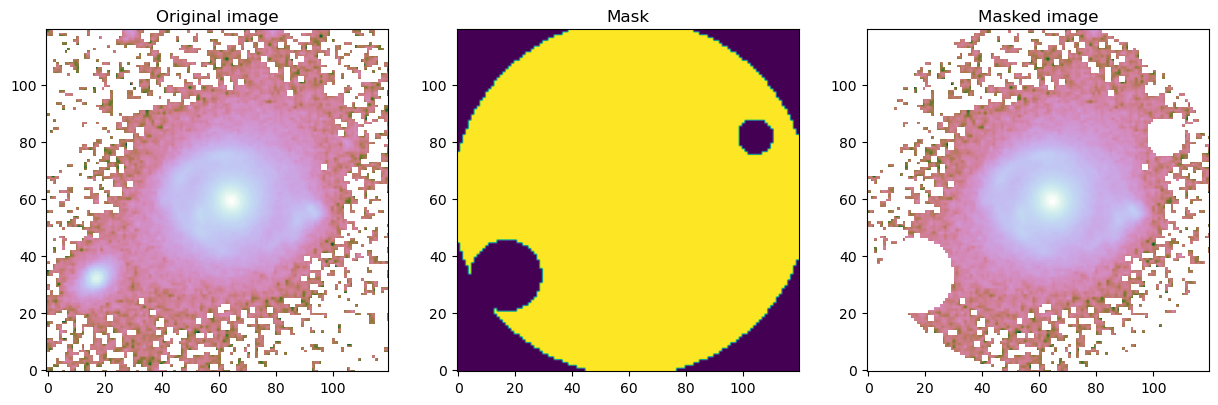

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

In [6]:
print("Mask dimension:", mask_img.shape, "\nMask type: ", type(mask_img))

Mask dimension: (120, 120) 
Mask type:  <class 'numpy.ndarray'>


## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [7]:
lens_model_list = ["EPL", "SHEAR"]


# beta, n_max, center_x, center_y
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]


lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [8]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2,
        "e1": -0.041,
        "e2": -0.095,
        "center_x": -0.2939,
        "center_y": -0.114,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1.9,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 3.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# 'SHEAR'
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.1035, "gamma2": 0.0391})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.1, "gamma2": -0.1})
kwargs_upper_lens.append({"gamma1": 0.2, "gamma2": 0.2})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# 1st Sersic profile. lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# for 'SERSIC_ELLIPSE'
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 1.0,
        "e1": -0.4998,
        "e2": -0.22137,
        "center_x": -0.27066,
        "center_y": -0.1640,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.01,
        "center_y": 0.01,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.7,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
# for ‘SHAPELETS’
fixed_source.append({"n_max": 5})
kwargs_source_init.append(
    {"beta": 0.145, "n_max": 5, "center_x": -0.27066, "center_y": 0.07217}
)
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.01, "center_y": 0.01})
kwargs_lower_source.append({"beta": 0, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.15, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

#https://lenstronomy.readthedocs.io/en/latest/lenstronomy.Sampling.html#lenstronomy.Sampling.parameters.Param

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

SyntaxError: invalid syntax. Perhaps you forgot a comma? (714415228.py, line 16)

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [56]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img],"check_positive_flux": True}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [57]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has-
    # independent solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of-
    # the linear coefficients demanded across the bands.
}

## Here the model fiting is done
Fixed 'gamma' inside fitting_kwargs_list: [lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings](https://lenstronomy.readthedocs.io/en/stable/lenstronomy.Workflow.html?highlight=update_settings#lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings)

In [11]:
start_time = time.time()

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)

end_time = time.time()
print(end_time - start_time, "total time needed for computation")

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0139234053447796 reduced X^2 of best position
-5771.252023222485 log likelihood
11384 effective number of data points
[{'theta_E': 1.5134806744872102, 'gamma': 2, 'e1': -0.11834539341381085, 'e2': -0.13422922960180692, 'center_x': -0.29381568159220073, 'center_y': -0.11619229847620677}, {'gamma1': 0.09087271488251004, 'gamma2': 0.03423982816002946, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0931537084894418, 'n_sersic': 1.0, 'e1': -0.3949480965839539, 'e2': 0.2318799537133239, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}, {'amp': 1, 'n_max': 5, 'beta': 0.14993036411750452, 'center_x': -0.5464697205694885, 'center_y': -0.14936722145348824}] source result
[{'amp': 1, 'R_sersic': 0.9578468959465047, 'n_sersic': 4.0, 'e1': 0.32110329105519186, 'e2': 0.08042152997055634, 'center_x': -0.3307501106339642, 'center_y': -0.09821869138168597}, {'amp': 1, 'R_sersic': 0.

In [11]:
#### save model ####

kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = "./DESIJ1554+0443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)
print("Result saved in: %s" % output_path)

NameError: name 'fitting_seq' is not defined

In [11]:
### load model ###

load_output_path = "./DESIJ1554+0443_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_
kwargs_result

{'kwargs_lens': [{'theta_E': 1.5049071454942418,
   'gamma': 2,
   'e1': -0.03142944020111962,
   'e2': -0.09799250158910201,
   'center_x': -0.30819684986594775,
   'center_y': -0.13848398895797967},
  {'gamma1': 0.11783022807885163,
   'gamma2': 0.04206611826391211,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': 1,
   'R_sersic': 0.0688443992940853,
   'n_sersic': 1.0,
   'e1': -0.4501990603846126,
   'e2': -0.07459561772663237,
   'center_x': -0.5482959649040664,
   'center_y': -0.15937736381538095},
  {'amp': 1,
   'n_max': 5,
   'beta': 0.1499784335589324,
   'center_x': -0.5482959649040664,
   'center_y': -0.15937736381538095}],
 'kwargs_lens_light': [{'amp': 1,
   'R_sersic': 0.8717125354390587,
   'n_sersic': 4.0,
   'e1': -0.023419404461170634,
   'e2': -0.055394182720308896,
   'center_x': -0.329654972248968,
   'center_y': -0.09663526349711914},
  {'amp': 1,
   'R_sersic': 0.8155529922878545,
   'n_sersic': 4.0,
   'e1': 0.46227750962172076,
   'e2': -0.1211188105

## Visualizing the fitted model

{'kwargs_lens': [{'theta_E': 1.5049071454942418, 'gamma': 2, 'e1': -0.03142944020111962, 'e2': -0.09799250158910201, 'center_x': -0.30819684986594775, 'center_y': -0.13848398895797967}, {'gamma1': 0.11783022807885163, 'gamma2': 0.04206611826391211, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.0688443992940853, 'n_sersic': 1.0, 'e1': -0.4501990603846126, 'e2': -0.07459561772663237, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}, {'amp': 1, 'n_max': 5, 'beta': 0.1499784335589324, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.8717125354390587, 'n_sersic': 4.0, 'e1': -0.023419404461170634, 'e2': -0.055394182720308896, 'center_x': -0.329654972248968, 'center_y': -0.09663526349711914}, {'amp': 1, 'R_sersic': 0.8155529922878545, 'n_sersic': 4.0, 'e1': 0.46227750962172076, 'e2': -0.12111881054760087, 'center_x': -0.329654972248968, 'center_y': -0.09663526349711914}], 'kwargs_ps': []

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:273: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color='k', alpha=1.)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:274: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap fir

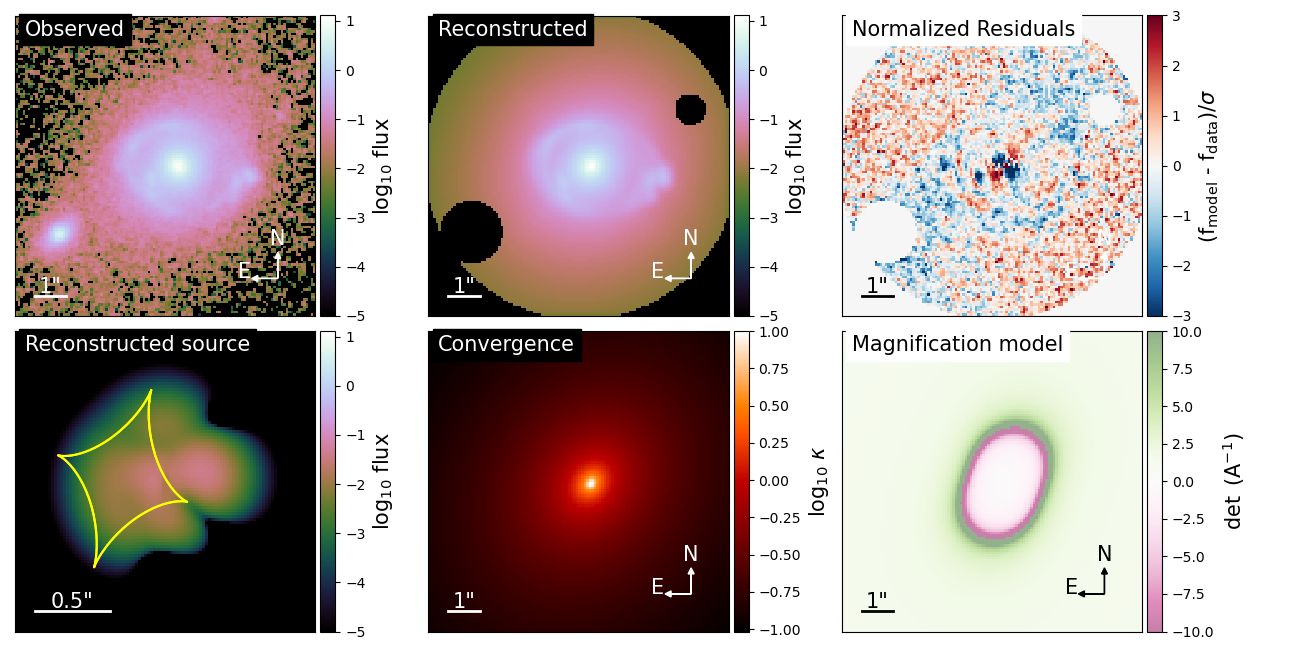

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


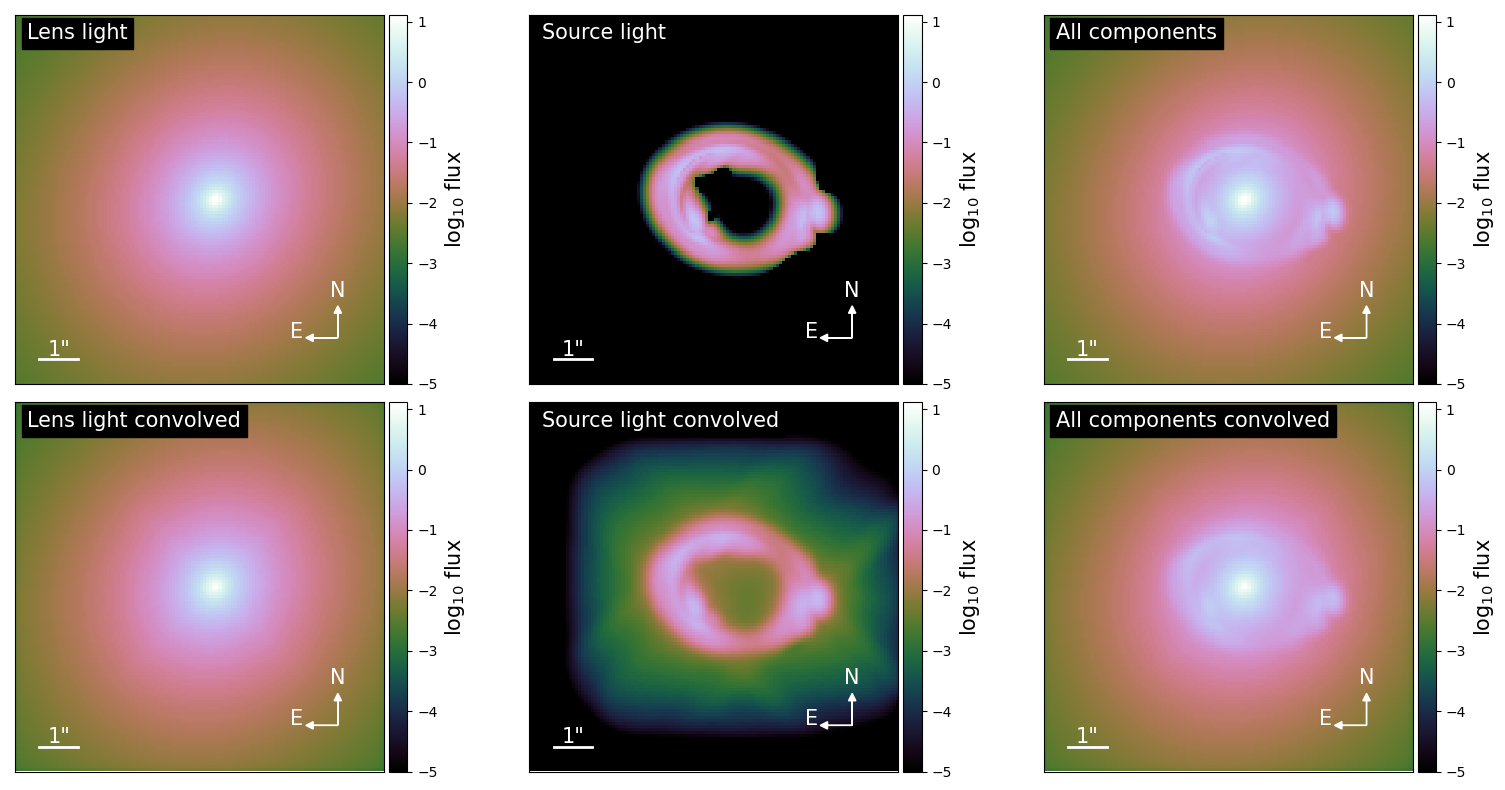

In [12]:
print(kwargs_result)
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.02,
    numPix=100,
    scale_size=0.5,
    with_caustics=True,
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

## MCMC

In [59]:
# from lenstronomy.Workflow.fitting_sequence import FittingSequence


# fitting_seq = FittingSequence(
#     kwargs_data_joint,
#     kwargs_model,
#     kwargs_constraints,
#     kwargs_likelihood,
#     kwargs_params,
# )

# fitting_kwargs_list_mcmc = [
#     ["MCMC", {"n_burn": 0, "n_run": 20, "n_walkers": 1000, 
#     "sigma_scale": 0.1, #"threadCount": 10,
#     "backend_filename": "backend_mcmc.h5", "start_from_backend":0
#     }],
# ]

# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
# kwargs_result = fitting_seq.best_fit()









mcmc_backend = "mcmc_backend.h5"

n_walkers = 100 #
n_step = 3500 #
n_burn = 0



backend_file = os.path.isfile(mcmc_backend)

# kwargs_lower_lens
# ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
if backend_file:
    print("background file found")
    fitting_kwargs_list_mcmc = [
        [
            "MCMC",
            {
                "n_burn": n_burn,
                "n_run": n_step,
                "n_walkers": n_walkers,
                "sigma_scale": 0.1,
                "backend_filename": mcmc_backend,
                "start_from_backend": True,
            },
        ]
    ]
else:
    print("creating background file")
    
    fitting_kwargs_list_mcmc = [
        ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
        [
            "MCMC",
            {
                "n_burn": n_burn,
                "n_run": n_step,
                "n_walkers": n_walkers,
                "sigma_scale": 0.1,
                "backend_filename": mcmc_backend,
                "start_from_backend": False,
            },
        ]
    ]
fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)


creating background file


100%|██████████| 3500/3500 [2:26:31<00:00,  2.51s/it]  

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 3500
8793.761721611023 time taken for MCMC sampling


In [60]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()
print(kwargs_result_mcmc)

{'kwargs_lens': [{'theta_E': 1.5341215823619652, 'gamma': 2, 'e1': -0.022870834230978652, 'e2': 0.17922818841829002, 'center_x': -0.3547343100376522, 'center_y': -0.2993772071168746}, {'gamma1': 0.1086104185212167, 'gamma2': 0.16616447292239495, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.14220825916432137, 'n_sersic': 1.0, 'e1': -0.4934453164661966, 'e2': 0.2523240661136815, 'center_x': -0.3785864925531389, 'center_y': -0.14247340600650718}, {'amp': 1, 'n_max': 5, 'beta': 0.1496567622431351, 'center_x': -0.3785864925531389, 'center_y': -0.14247340600650718}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.2372419211871377, 'n_sersic': 4.0, 'e1': 0.03213472070756287, 'e2': -0.19230829828708546, 'center_x': -0.324863419899643, 'center_y': -0.09294050231475962}, {'amp': 1, 'R_sersic': 0.5223357059864855, 'n_sersic': 4.0, 'e1': -0.07038556575994866, 'e2': 0.15055696218303516, 'center_x': -0.324863419899643, 'center_y': -0.09294050231475962}], 'kwargs_ps': [], 'kwar

In [61]:
# reader = emcee.backends.HDFBackend("mcmc_backend.h5", read_only=True)
# flatchain = reader.get_chain(flat=True)

In [62]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)

(350000, 21)


/tmp/ipykernel_12808/619227355.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 5000, N_walkers: 70, N_params: 21
theta_E_lens0 1.5381 ± 0.0444
e1_lens0 -0.0213 ± 0.0170
e2_lens0 0.1581 ± 0.0258
center_x_lens0 -0.3513 ± 0.1333
center_y_lens0 -0.2956 ± 0.1393
gamma1_lens1 0.1054 ± 0.0059
gamma2_lens1 0.1485 ± 0.0378
R_sersic_source_light0 0.1534 ± 0.0086
e1_source_light0 -0.4634 ± 0.0652
e2_source_light0 0.2304 ± 0.0393
center_x_source_light0 -0.3741 ± 0.0350
center_y_source_light0 -0.1434 ± 0.0110
beta_source_light1 0.1497 ± 0.0008
R_sersic_lens_light0 1.2074 ± 0.0596
e1_lens_light0 0.0168 ± 0.0191
e2_lens_light0 -0.1900 ± 0.0132
center_x_lens_light0 -0.3255 ± 0.0017
center_y_lens_light0 -0.0943 ± 0.0010
R_sersic_lens_light1 0.5230 ± 0.0450
e1_lens_light1 -0.0456 ± 0.0456
e2_lens_light1 0.1821 ± 0.0477


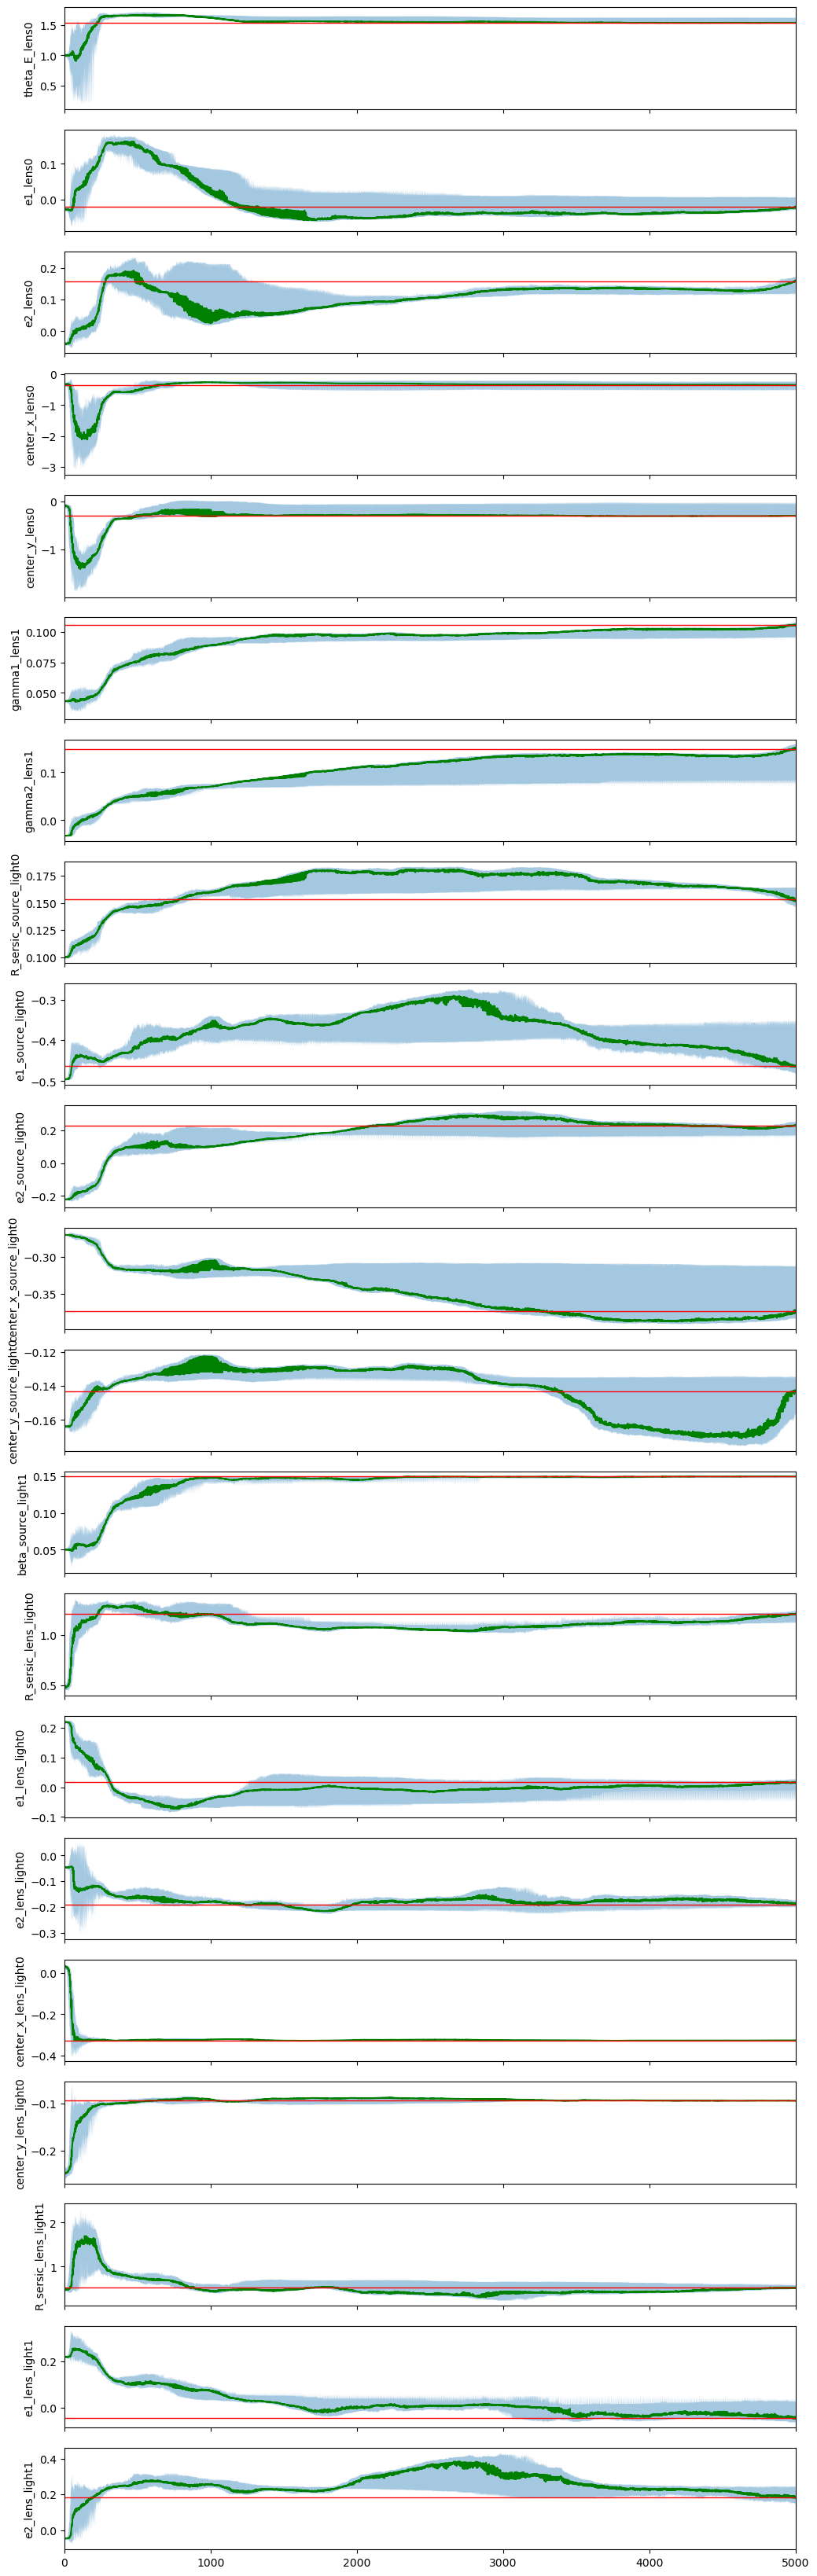

In [64]:
# if len(chain_list) > 0:
#     for i, chain in enumerate(chain_list):
#         print(f"Chain {i + 1}:")
#         print("Sampler type:", chain[0])
#         print("Parameter names:", chain[2])
#         print("Shape of samples:", chain[1].shape)
#         print("")

#     # Alternatively, you can access the last chain directly
#     last_chain = chain_list[-1]
#     last_samples = last_chain[1]
#     last_param_names = last_chain[2]
#     print("Last Chain:")
#     print("Sampler type:", last_chain[0])
#     print("Parameter names:", last_param_names)
#     print("Shape of samples:", last_samples.shape)
# else:
#     print("No MCMC chains available.")







if not samples_mcmc == []:

    # n_params = samples_mcmc.shape[1]

    # n_walkers = walker_ratio * n_params
    # n_step = int(samples_mcmc.shape[0] / n_walkers)



    n_params = samples_mcmc.shape[1]
    n_walkers = 70 #1000
    n_step = int(samples_mcmc.shape[0] / n_walkers) #100
    n_burn = 1500

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

Number of non-linear parameters in the MCMC process: 21
Parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 350000
350000
Shape of samples_mcmc_cut: (350, 21)


/tmp/ipykernel_12808/3964755636.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


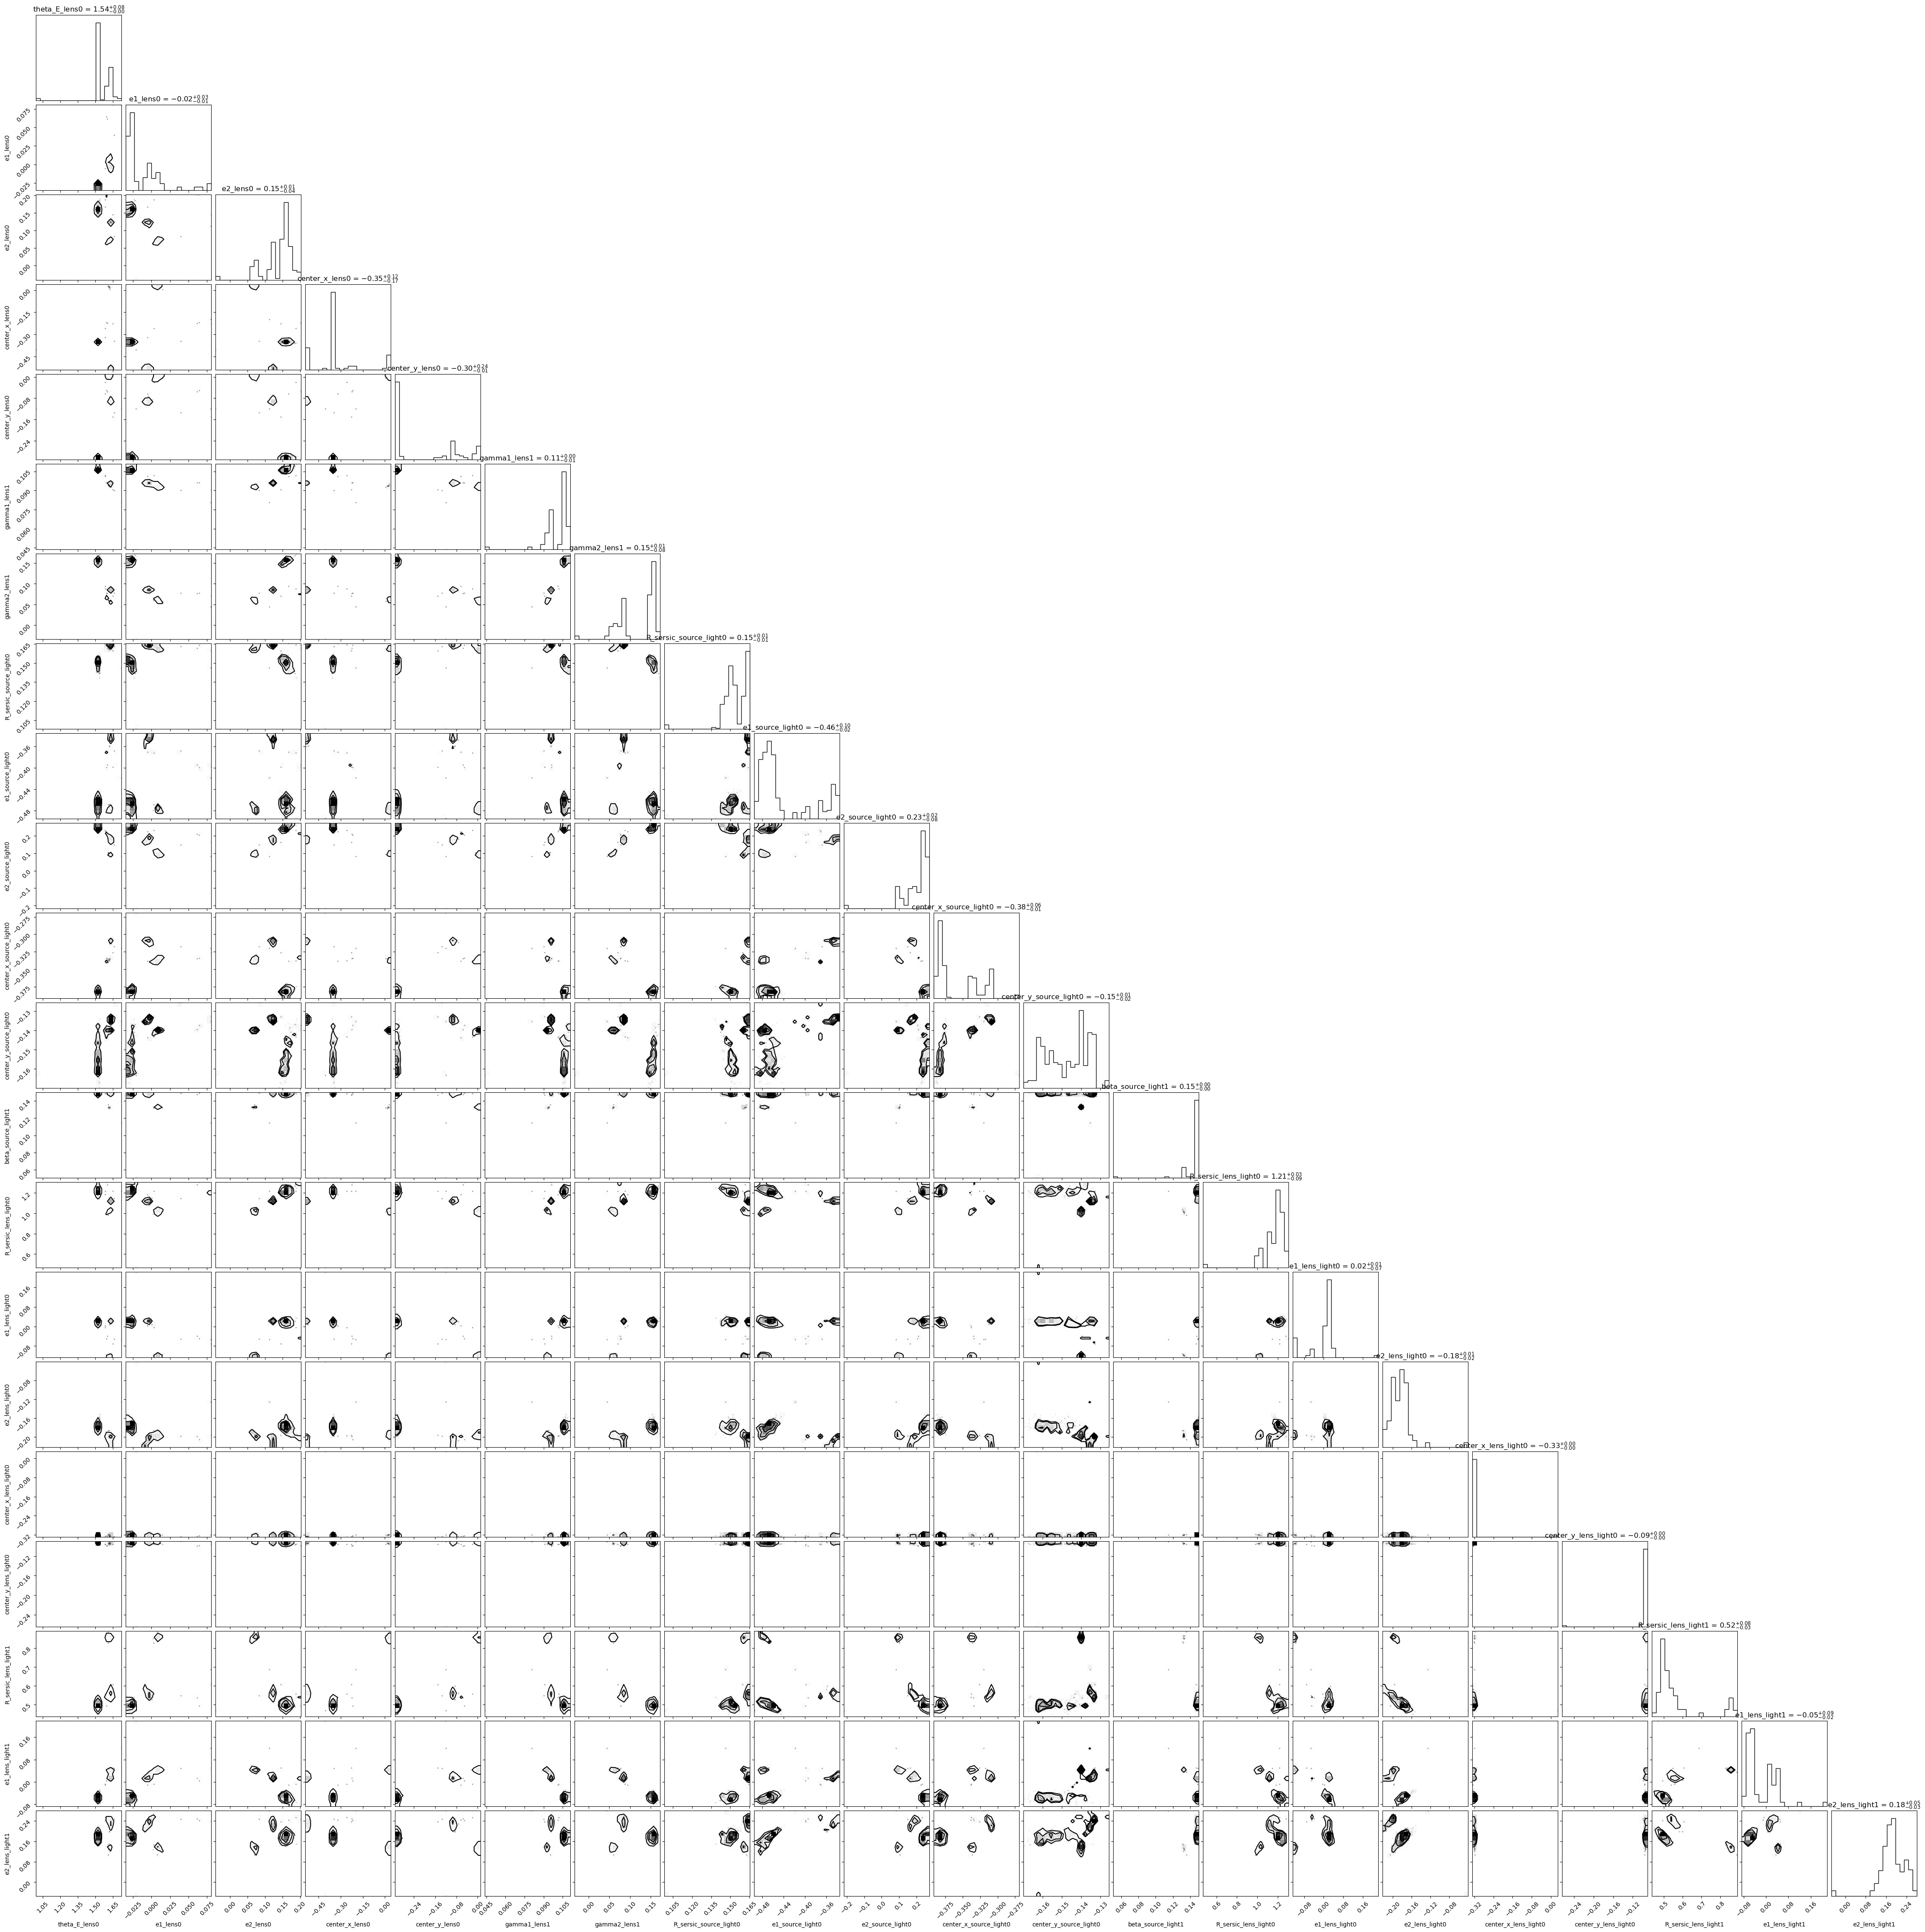

In [65]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 4950
        thin = 10
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


-1.144096378457174 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1440963784571734


/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:273: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color='k', alpha=1.)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:274: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap fir

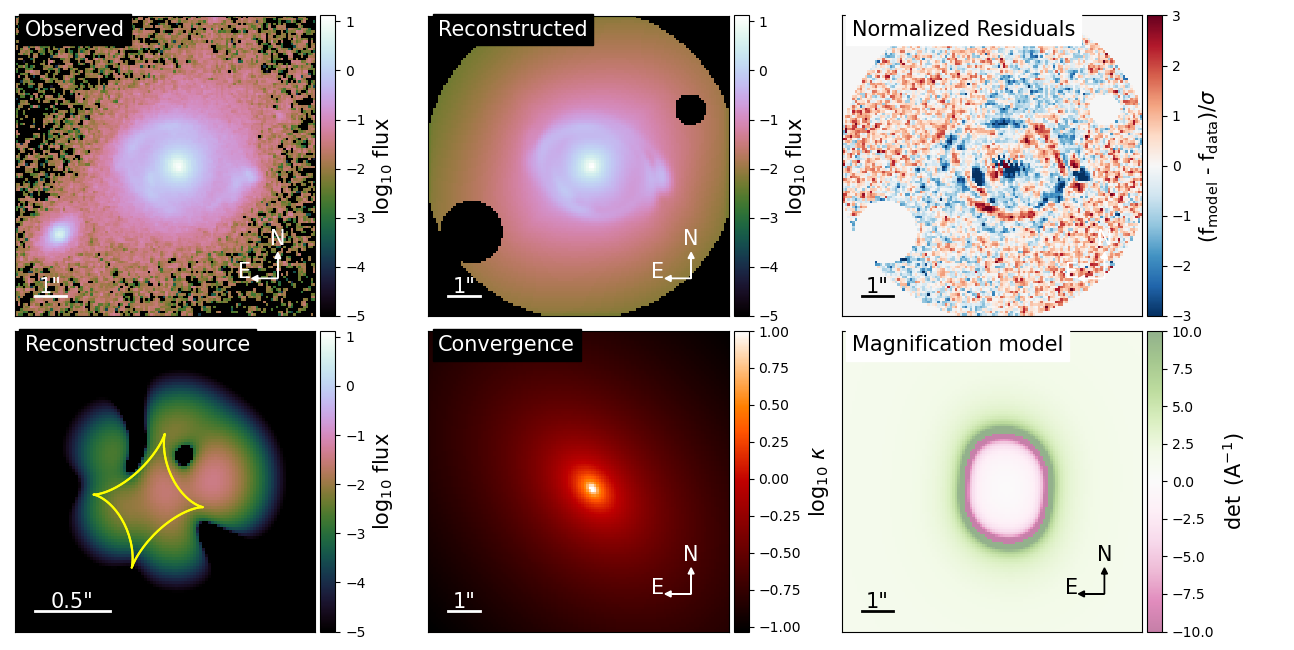

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


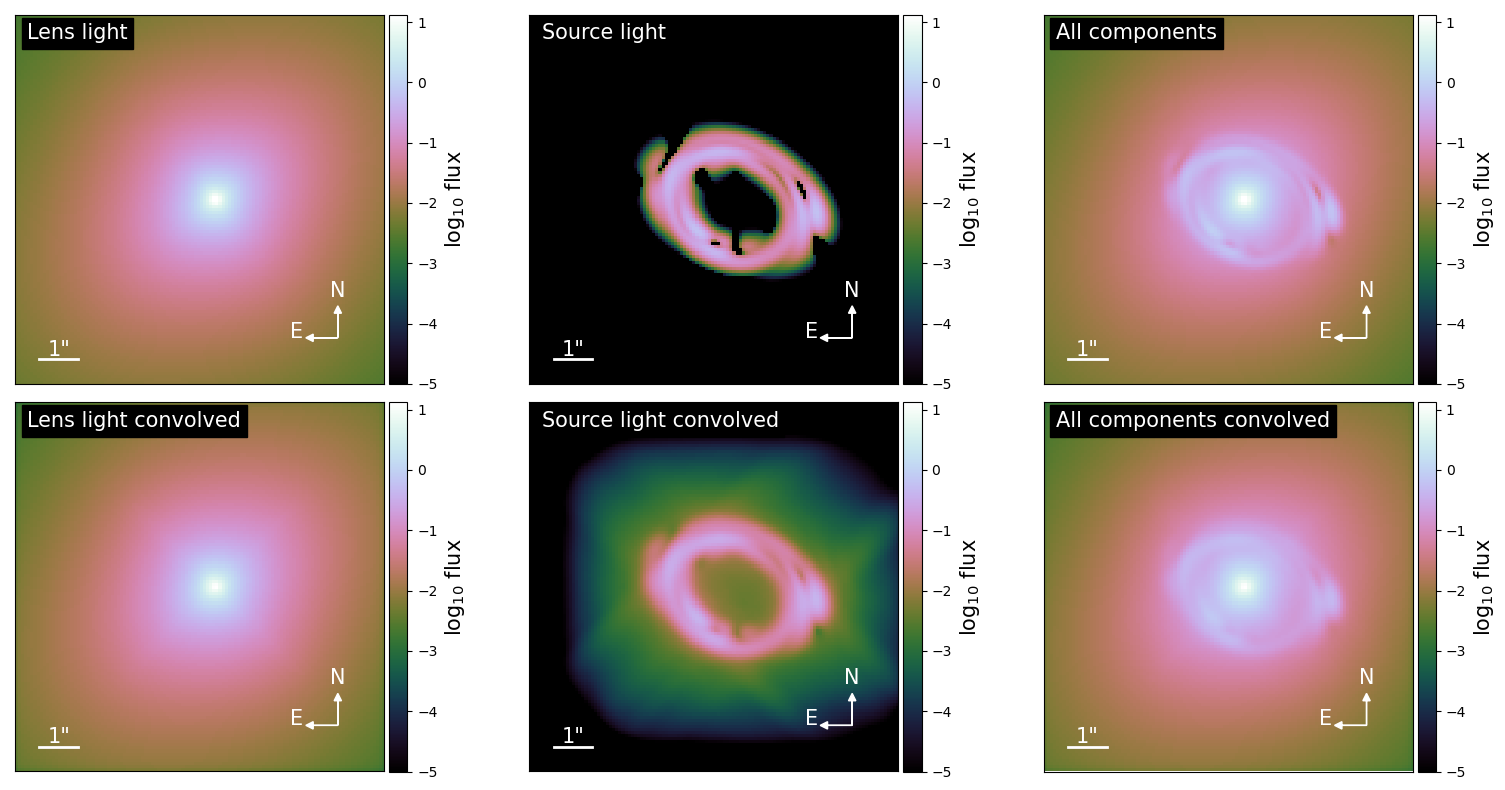

{'kwargs_lens': [{'theta_E': 1.5341215823619652, 'gamma': 2, 'e1': -0.022870834230978652, 'e2': 0.17922818841829002, 'center_x': -0.3547343100376522, 'center_y': -0.2993772071168746}, {'gamma1': 0.1086104185212167, 'gamma2': 0.16616447292239495, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 0.05015552099620338, 'R_sersic': 0.14220825916432137, 'n_sersic': 1.0, 'e1': -0.4934453164661966, 'e2': 0.2523240661136815, 'center_x': -0.3785864925531389, 'center_y': -0.14247340600650718}, {'amp': array([104.0894698 , -38.20178716, -40.85260586,  52.60868634,
        -6.34690405,   8.42058203, -63.21131032,   3.41996418,
        11.83334701,  10.46519103,  65.02505893, -16.71132939,
        -7.80075451,  -9.23908667,  14.36894416, -19.80097241,
         9.0012798 ,  15.56113256,   3.17155553, -10.74508849,
        -0.33397827]), 'n_max': 5, 'beta': 0.1496567622431351, 'center_x': -0.3785864925531389, 'center_y': -0.14247340600650718}], 'kwargs_lens_light': [{'amp': 23.666989897628365, 'R_ser

In [66]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

In [ ]:
{'kwargs_lens': [{'theta_E': 1.5091842328739984, 'gamma': 1.8901014239497564, 'e1': -0.041099116379646354, 'e2': -0.0956621081003019, 'center_x': -0.29394975901765913, 'center_y': -0.11433919329114163}, {'gamma1': 0.10353333874128645, 'gamma2': 0.03911900330449401, 'ra_0': 0, 'dec_0': 0}], 
 'kwargs_source': [{'amp': 13.000988741441493, 'R_sersic': 0.19945103584868337, 'n_sersic': 1.0, 'e1': -0.4138424403687778, 'e2': -0.3948397889509597, 'center_x': -0.47458198488536235, 'center_y': -0.0883675283016383}, 
                   {'amp': array([ 84.96398627, -30.59160518, -19.34648437,  91.70154188,
        -3.96773323,  -4.56338646, -43.17135789,  12.25814388,
        12.10668521,  -7.56215783,  33.46001008, -18.81097522,
       -17.97431499,  15.16432014,  16.6892171 ,  -2.90940515,
        -7.65698778,  24.19051357, -12.4772358 ,  -7.26126556,
         1.30966518]), 'n_max': 5, 'beta': 0.14522999080218182, 'center_x': -0.47458198488536235, 'center_y': -0.0883675283016383}], 

'kwargs_lens_light': [{'amp': -61.68322423955752, 'R_sersic': 1.671186256462338, 'n_sersic': 4.0, 'e1': 0.04978152617559737, 'e2': 0.13602166202537538, 'center_x': -0.33034457405127343, 'center_y': -0.09603204602418842}, {'amp': 119.77363741163205, 'R_sersic': 1.3578637501676494, 'n_sersic': 4.0, 'e1': 0.03020504153176204, 'e2': 0.07777787869722155, 'center_x': -0.33034457405127343, 'center_y': -0.09603204602418842}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_ext

In [100]:
### save mcmc model ###
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = 2750  # can be not `None` for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "./DESIJ1554+0443_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

In [139]:
### load mcmc model ###
load_output_path_mcmc = "./DESIJ1554+0443_mcmc_output.joblib"
with open(load_output_path_mcmc, "rb") as f:
    [input_, output_] = joblib.load(f)
    # print("input:\n",input_, "\noutput:\n",output_)
(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_
# print(input_)

kwargs_result, multi_band_list_out, fit_output = output_
kwargs_result
#dict_keys(['kwargs_lens', 'kwargs_source', 'kwargs_lens_light', 'kwargs_ps', 'kwargs_special', 'kwargs_extinction'])

{'kwargs_lens': [{'theta_E': 1.5091842328739984,
   'gamma': 1.8901014239497564,
   'e1': -0.041099116379646354,
   'e2': -0.0956621081003019,
   'center_x': -0.29394975901765913,
   'center_y': -0.11433919329114163},
  {'gamma1': 0.10353333874128645,
   'gamma2': 0.03911900330449401,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': 13.000988741441493,
   'R_sersic': 0.19945103584868337,
   'n_sersic': 1.0,
   'e1': -0.4138424403687778,
   'e2': -0.3948397889509597,
   'center_x': -0.47458198488536235,
   'center_y': -0.0883675283016383},
  {'amp': array([ 84.96398627, -30.59160518, -19.34648437,  91.70154188,
           -3.96773323,  -4.56338646, -43.17135789,  12.25814388,
           12.10668521,  -7.56215783,  33.46001008, -18.81097522,
          -17.97431499,  15.16432014,  16.6892171 ,  -2.90940515,
           -7.65698778,  24.19051357, -12.4772358 ,  -7.26126556,
            1.30966518]),
   'n_max': 5,
   'beta': 0.14522999080218182,
   'center_x': -0.47458198488536235,

-0.8800025710573163 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8800025710573025


/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:273: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color='k', alpha=1.)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:274: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

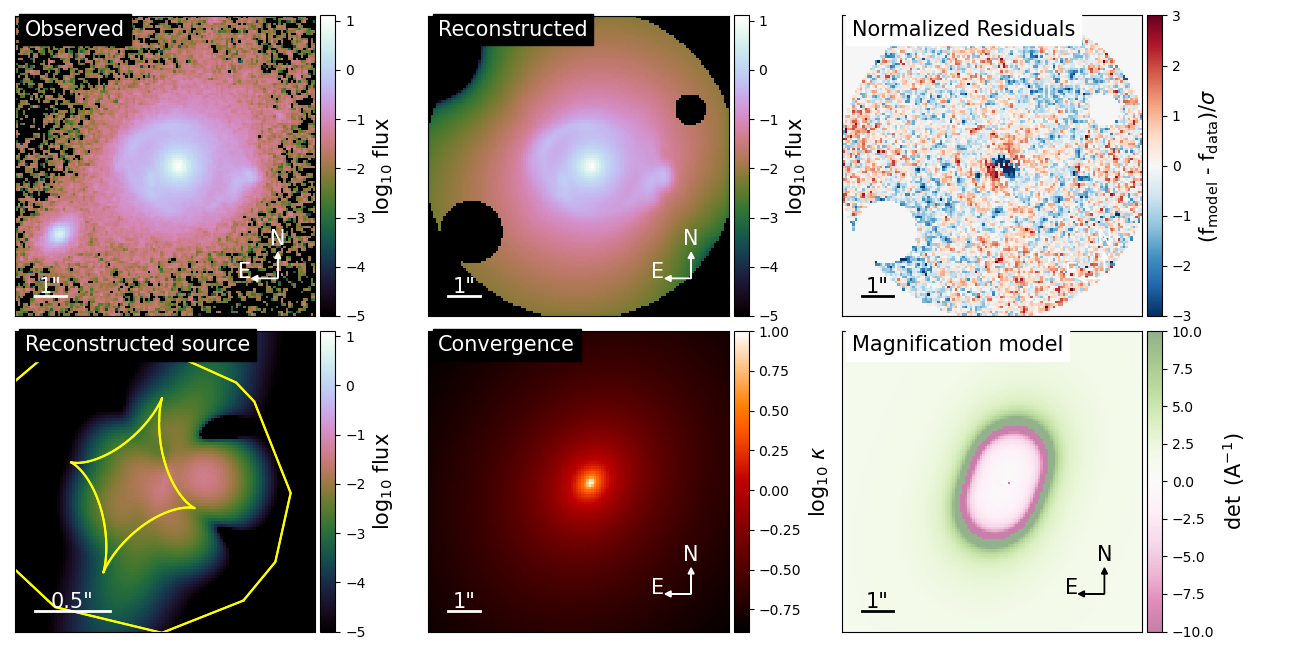

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


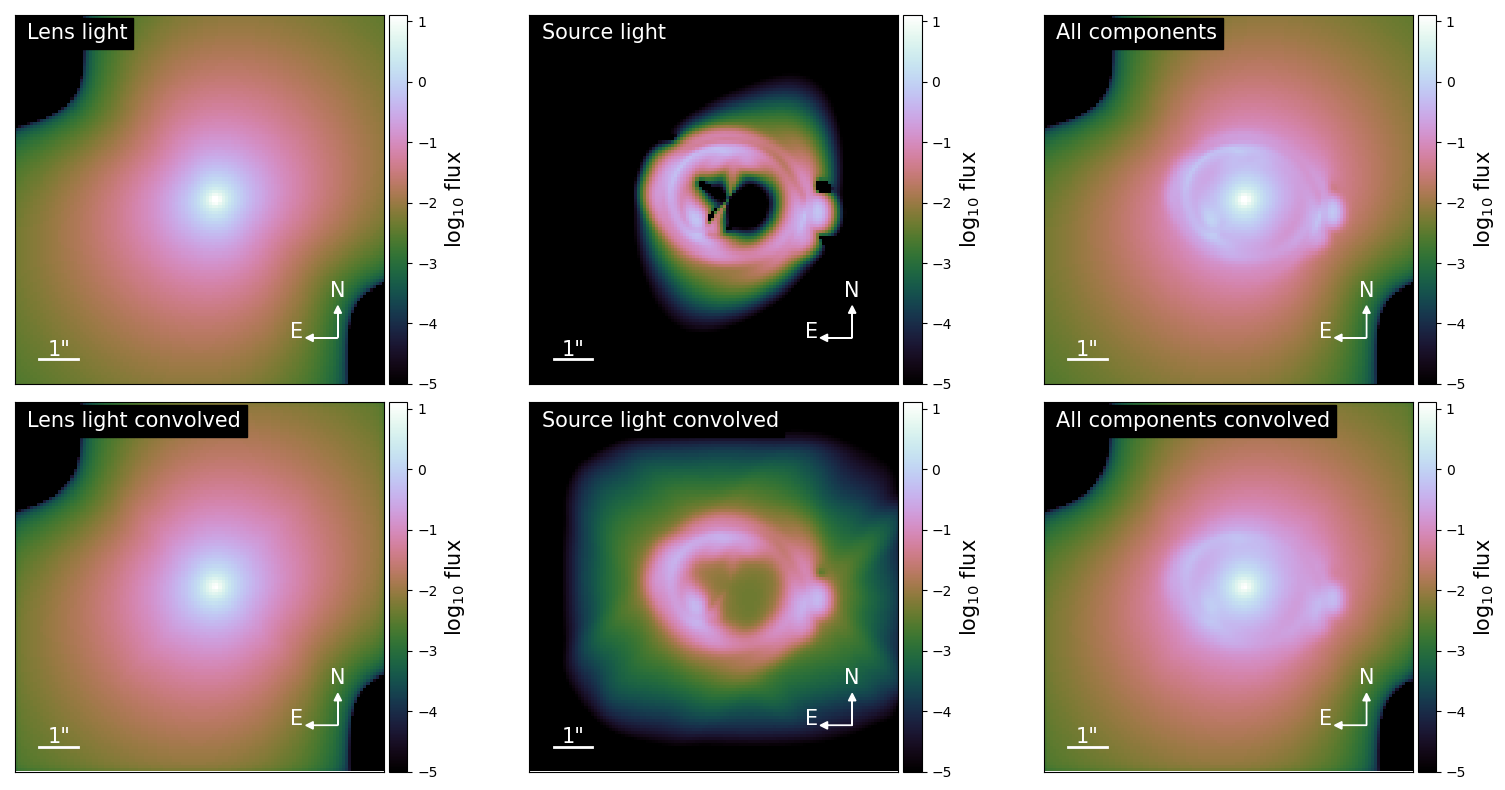

{'kwargs_lens': [{'theta_E': 1.5091842328739984, 'gamma': 1.8901014239497564, 'e1': -0.041099116379646354, 'e2': -0.0956621081003019, 'center_x': -0.29394975901765913, 'center_y': -0.11433919329114163}, {'gamma1': 0.10353333874128645, 'gamma2': 0.03911900330449401, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 13.000988741441493, 'R_sersic': 0.19945103584868337, 'n_sersic': 1.0, 'e1': -0.4138424403687778, 'e2': -0.3948397889509597, 'center_x': -0.47458198488536235, 'center_y': -0.0883675283016383}, {'amp': array([ 84.96398627, -30.59160518, -19.34648437,  91.70154188,
        -3.96773323,  -4.56338646, -43.17135789,  12.25814388,
        12.10668521,  -7.56215783,  33.46001008, -18.81097522,
       -17.97431499,  15.16432014,  16.6892171 ,  -2.90940515,
        -7.65698778,  24.19051357, -12.4772358 ,  -7.26126556,
         1.30966518]), 'n_max': 5, 'beta': 0.14522999080218182, 'center_x': -0.47458198488536235, 'center_y': -0.0883675283016383}], 'kwargs_lens_light': [{'amp': -61.6

In [140]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)